# pyControl - pyPhotometry data synchronisation example

This notebook shows how to synchronise [pyControl](https://pycontrol.readthedocs.io) behavioural data with [pyPhotometry](https://pyphotometry.readthedocs.io) recordings using pyControl's rsync [synchronisation](https://pycontrol.readthedocs.io/en/latest/user-guide/synchronisation/) tool.

The data are calcium signals recorded from dopamine neuron terminals in nucleus accumbens in a task where rewards became available in a nose-poke on a random interval schedule. See [Akam & Walton 2019](https://rdcu.be/bpvvJ) for details.

Import the standard python modules needed for the analysis.

In [5]:
import os
import numpy as  np
import pylab as plt

Import the pyControl data import and synchronisation modules (found in the pyControl [tools](https://bitbucket.org/takam/pycontrol/src/default/tools/) folder), and the pyPhotometry data import module (found in the pyPhotometry [tools](https://bitbucket.org/takam/pyphotometry/src/default/tools/) folder).  The pyControl and pyPhotometry `data_import.py` module files have been renamed `pyControl_import.py` and `pyPhotometry_import.py` to avoid a name collision.

In [6]:
from pyControl_import import Session
from pyPhotometry_import import import_ppd
from rsync import Rsync_aligner

Import the data files.

In [8]:
data_folder = 'data' # Here the data folder is a relative path but an absolute path can also be used.

behaviour_filepath  = os.path.join(data_folder, 'P14-NAc-L-2018-11-29-143413.txt')
photometry_filepath = os.path.join(data_folder, 'P14-NAc-L-2018-11-29-143403.ppd')

behaviour_session = Session(behaviour_filepath)
photometry_data = import_ppd(photometry_filepath)

Importing data file: P14-NAc-L-2018-11-29-143413.txt


Setup an `Rsync_aligner` object to convert behavioural event times recorded by pyControl to photometry signal sample numbers.

In [9]:
pulse_times_beh = behaviour_session.times['rsync'] # Sync pulse times recorded by pyControl.

pulse_samples = 1+np.where(np.diff(photometry_data['digital_2']) == 1)[0] # Photometry samples when sync pulse occured.

aligner = Rsync_aligner(pulse_times_A=pulse_times_beh, pulse_times_B=pulse_samples, # Instantiate aligner object.
                        units_B=1000/photometry_data['sampling_rate'])

Extract photometry traces around rewards.

In [10]:
n = 50                     # number of reward to average.
window_ms = [-1000, 4000]  # time window around reward to plot in ms.

window_samples = (np.array(window_ms)*photometry_data['sampling_rate']/1000).astype(int) # time window around reward in samples.

reward_times = behaviour_session.times['reward'][:n] # Times when first n rewards occured.

reward_samples = aligner.A_to_B(reward_times).astype(int) # Convert reward times to photometry sample numbers.

reward_traces = np.vstack([
    photometry_data['analog_1_filt'][rs+window_samples[0]:rs+window_samples[1]] for rs in reward_samples]) 

Plot average calcium signal around reward with standard error shown as shaded area.

Text(0, 0.5, 'GCaMP signal (V)')

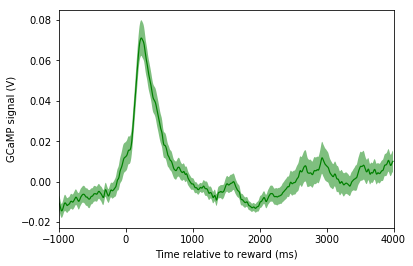

In [14]:
mean_trace = np.mean(reward_traces,0)                                # Average reward response
trace_sem  = np.std(reward_traces,0)/np.sqrt(reward_traces.shape[0]) # Reward response standard error.

rel_time = np.arange(*window_samples) * 1000/photometry_data['sampling_rate'] # Time relative to reward.

plt.fill_between(rel_time, mean_trace-trace_sem, mean_trace+trace_sem, facecolor='g', alpha=0.5)
plt.plot(rel_time, mean_trace, 'g', linewidth=1.2)
plt.xlim(*window_ms)
plt.xlabel('Time relative to reward (ms)')    
plt.ylabel('GCaMP signal (V)')